In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [38]:
FILE_PATH = "train.csv"
df = pd.read_csv(FILE_PATH)

In [39]:
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [40]:
def basic_clean(df):
  df.columns = df.columns.str.lower()
  df.columns = df.columns.str.replace(" ", "_")
  df.rename(columns={'time_taken(min)': 'time_taken'}, inplace=True)
  df.drop(['id', 'delivery_person_id'], axis=1, inplace=True)
  df['time_taken'] = df['time_taken'].str.replace('(min) ', '')
  return df

In [41]:
df = basic_clean(df)

In [42]:
df.describe(include='object')

,delivery_person_age,delivery_person_ratings,order_date,time_orderd,time_order_picked,weatherconditions,road_traffic_density,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken
count,45593,45593,45593,45593,45593,45593,45593,45593,45593,45593,45593,45593,45593
unique,23,29,44,177,193,7,5,4,4,5,3,4,45
top,35,4.8,15-03-2022,NaN,21:30:00,conditions Fog,Low,Snack,motorcycle,1,No,Metropolitian,26
freq,2262,7148,1192,1731,496,7654,15477,11533,26435,28159,44469,34093,2123


In [43]:
def handle_null_values(df):
  cols_to_clean = df.columns
  for col in cols_to_clean:
    df[col] = df[col].astype(str).str.replace('NaN ', '', regex=False)
    df[col] = df[col].astype(str).str.replace('NaN', '', regex=False)
    df[col] = df[col].astype(str).str.replace('nan', '', regex=False)
    df[col] = df[col].replace('', np.nan)
  rows_with_nulls = df.isnull().any(axis=1).sum()
  df.dropna(inplace=True)
  print(df.shape)
  return df

In [44]:
df = handle_null_values(df)
df.isnull().sum()

(41368, 18)


,0
delivery_person_age,0
delivery_person_ratings,0
restaurant_latitude,0
restaurant_longitude,0
delivery_location_latitude,0
delivery_location_longitude,0
order_date,0
time_orderd,0
time_order_picked,0
weatherconditions,0


In [45]:
numeric_cols = ['delivery_person_age',
       'delivery_person_ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_location_latitude',
       'delivery_location_longitude','vehicle_condition','multiple_deliveries','time_taken']

In [46]:
def convert_datatypes(df):
  for col in numeric_cols:
    print(col)
    df[col] = pd.to_numeric(df[col])
  return df

In [47]:
df = convert_datatypes(df)

delivery_person_age
delivery_person_ratings
restaurant_latitude
restaurant_longitude
delivery_location_latitude
delivery_location_longitude
vehicle_condition
multiple_deliveries
time_taken


In [48]:
cat_cols = df.select_dtypes(include='object').columns

In [49]:
def visualize_outliers(df):
  numeric_df = df[numeric_cols]
  plt.figure(figsize=(15, 10))
  for i, col in enumerate(numeric_df.columns):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x=df[col])
    plt.title(col)
  plt.tight_layout()
  plt.show()

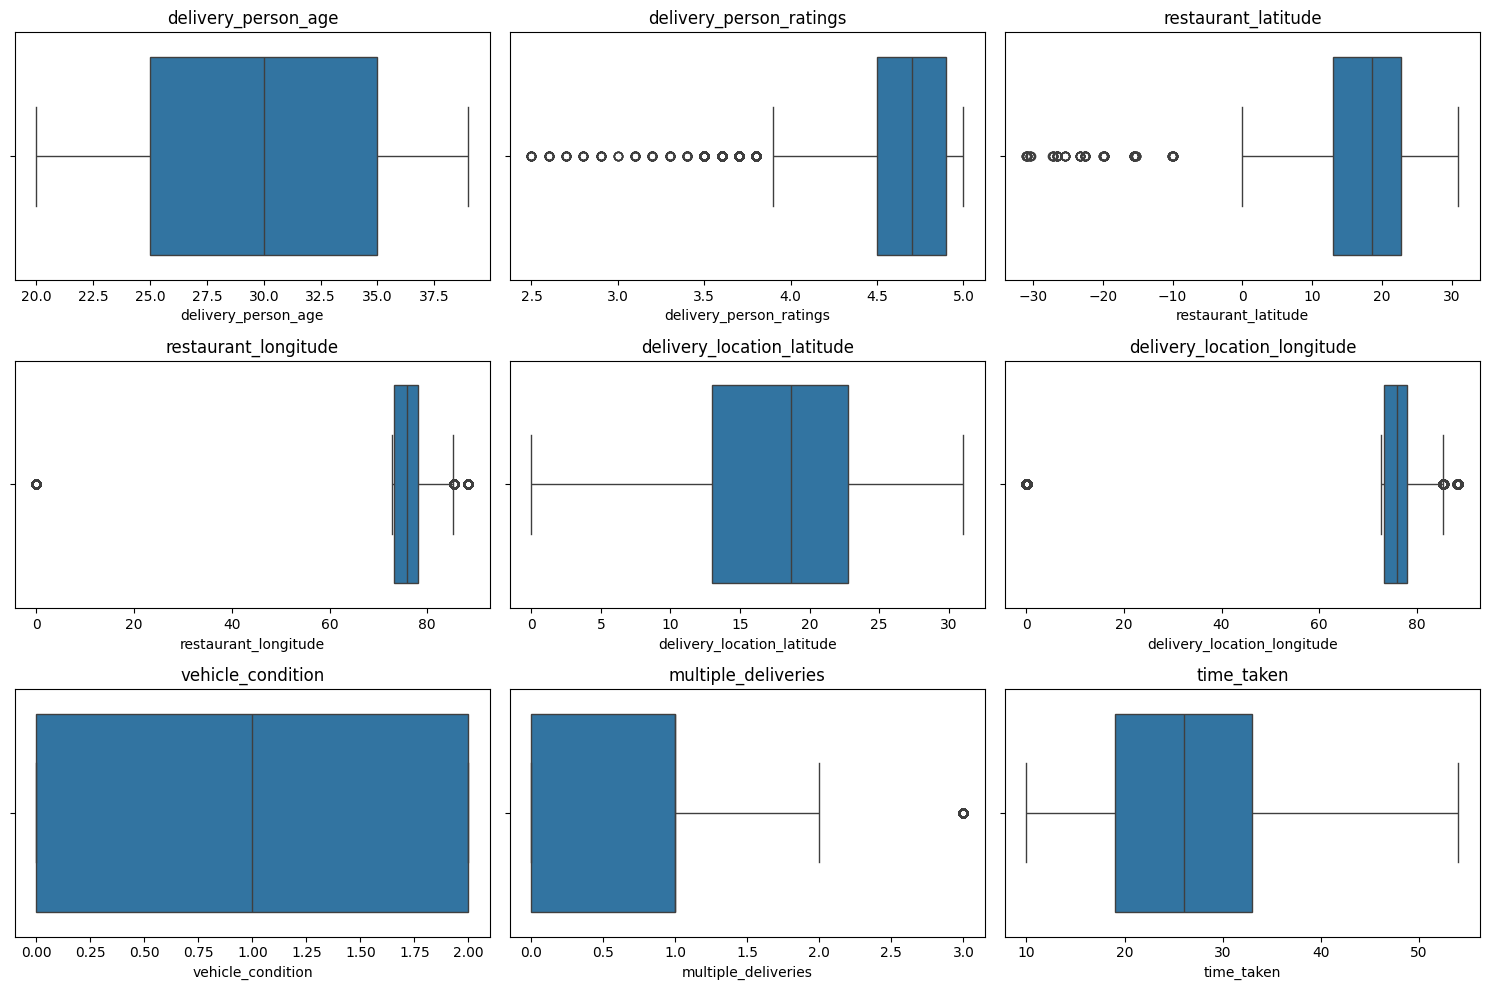

In [50]:
visualize_outliers(df)

In [51]:
def handle_outliers(df):
  df['delivery_person_ratings'] = df['delivery_person_ratings'].apply(lambda x: 5 if x > 5 else x)
  df = df[-((df["restaurant_latitude"]==0.0) & (df["restaurant_longitude"]==0.0))]
  df = df[df['delivery_person_ratings'] >= 3]
  return df

In [52]:
df = handle_outliers(df)

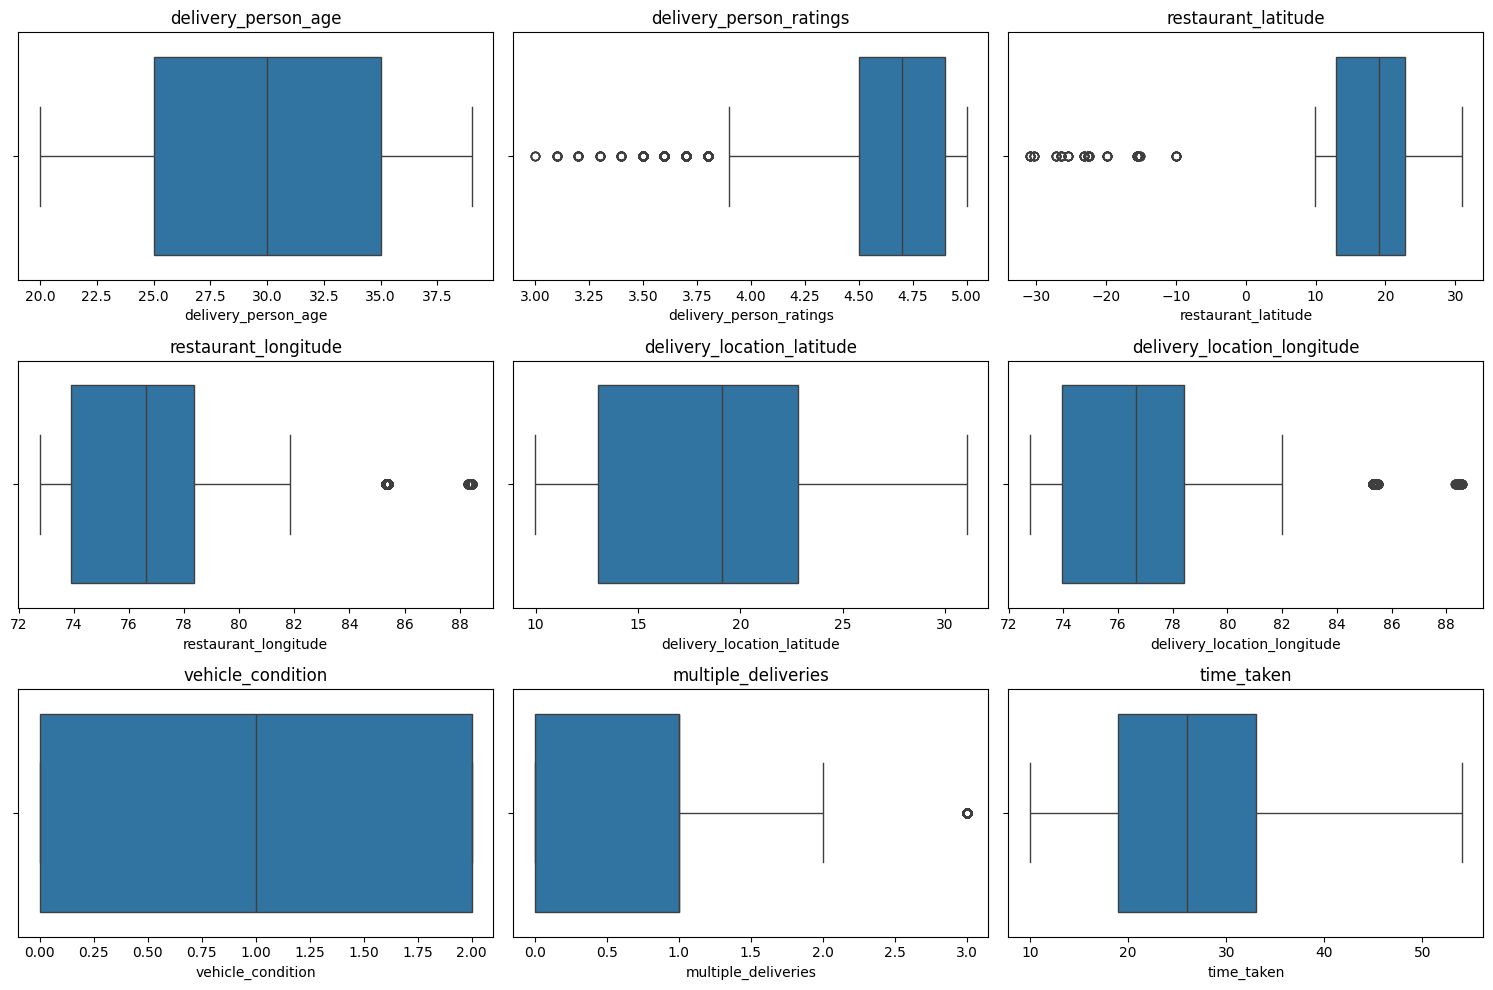

In [53]:
visualize_outliers(df)

**Feature Engineering**

In [54]:
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points
    on the Earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    km = 6371 * c  # Radius of earth in kilometers. Use 3956 for miles
    return km

In [55]:
def basic_feature_engineering(df):
  # adding distance col and remove coords
  df['distance'] = df.apply(lambda row: haversine_distance(row['restaurant_latitude'], row['restaurant_longitude'], row['delivery_location_latitude'], row['delivery_location_longitude']), axis=1)
  df.drop(['restaurant_latitude', 'restaurant_longitude', 'delivery_location_latitude', 'delivery_location_longitude'], axis=1, inplace=True)

  # working on time and date cols
  df['order_datetime'] = pd.to_datetime(df['order_date'] + ' ' + df['time_orderd'])
  df['picked_datetime'] = pd.to_datetime(df['order_date'] + ' ' + df['time_order_picked'])
  # change picked_datetime when pickup is next day
  mask = df['picked_datetime'] < df['order_datetime']
  df.loc[mask, 'picked_datetime'] += pd.Timedelta(days=1)
  df['prep_time'] = (df['picked_datetime'] - df['order_datetime']).dt.total_seconds() / 60  # Convert to minutes

  # remove useless columns
  df.drop(['order_datetime', 'picked_datetime', 'order_date', 'time_orderd', 'time_order_picked'], axis=1, inplace=True)
  return df

In [56]:
df = basic_feature_engineering(df)

/tmp/ipython-input-1773606463.py:7: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['order_datetime'] = pd.to_datetime(df['order_date'] + ' ' + df['time_orderd'])
/tmp/ipython-input-1773606463.py:8: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['picked_datetime'] = pd.to_datetime(df['order_date'] + ' ' + df['time_order_picked'])


In [57]:
df.sample(4)

,delivery_person_age,delivery_person_ratings,weatherconditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken,distance,prep_time
4938,39,4.6,conditions Fog,Low,0,Drinks,motorcycle,1,No,Metropolitian,43,17.077949,10.0
2247,20,4.8,conditions Windy,Low,1,Buffet,scooter,1,No,Urban,12,1.498153,5.0
30725,33,4.1,conditions Fog,High,2,Snack,scooter,1,No,Metropolitian,36,6.210416,15.0
1112,31,4.9,conditions Windy,Jam,2,Meal,scooter,1,No,Metropolitian,29,13.972195,5.0


**Visualization**

In [58]:
cat_cols = df.select_dtypes(include='object').columns

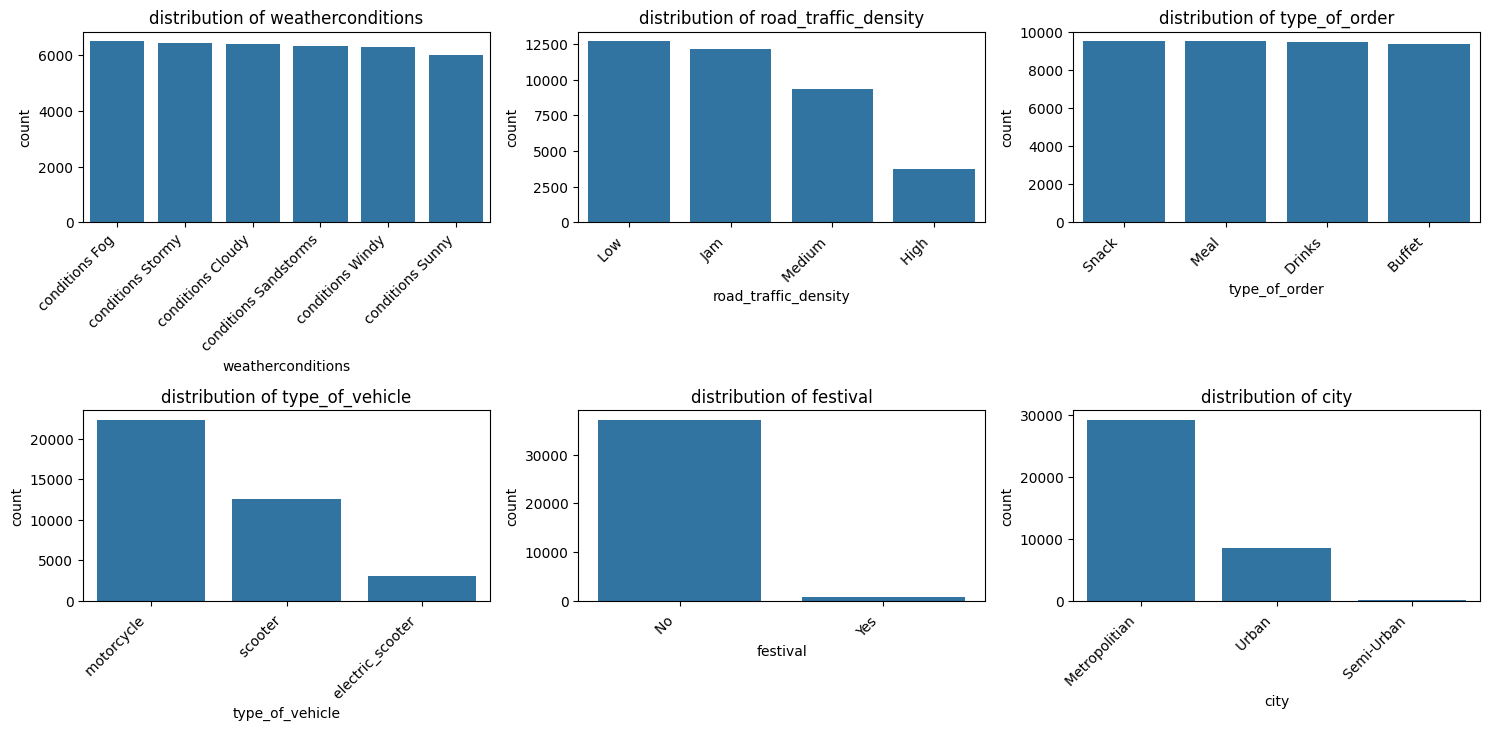

In [59]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_cols):
    plt.subplot(3, 3, i + 1)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'distribution of {col}')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

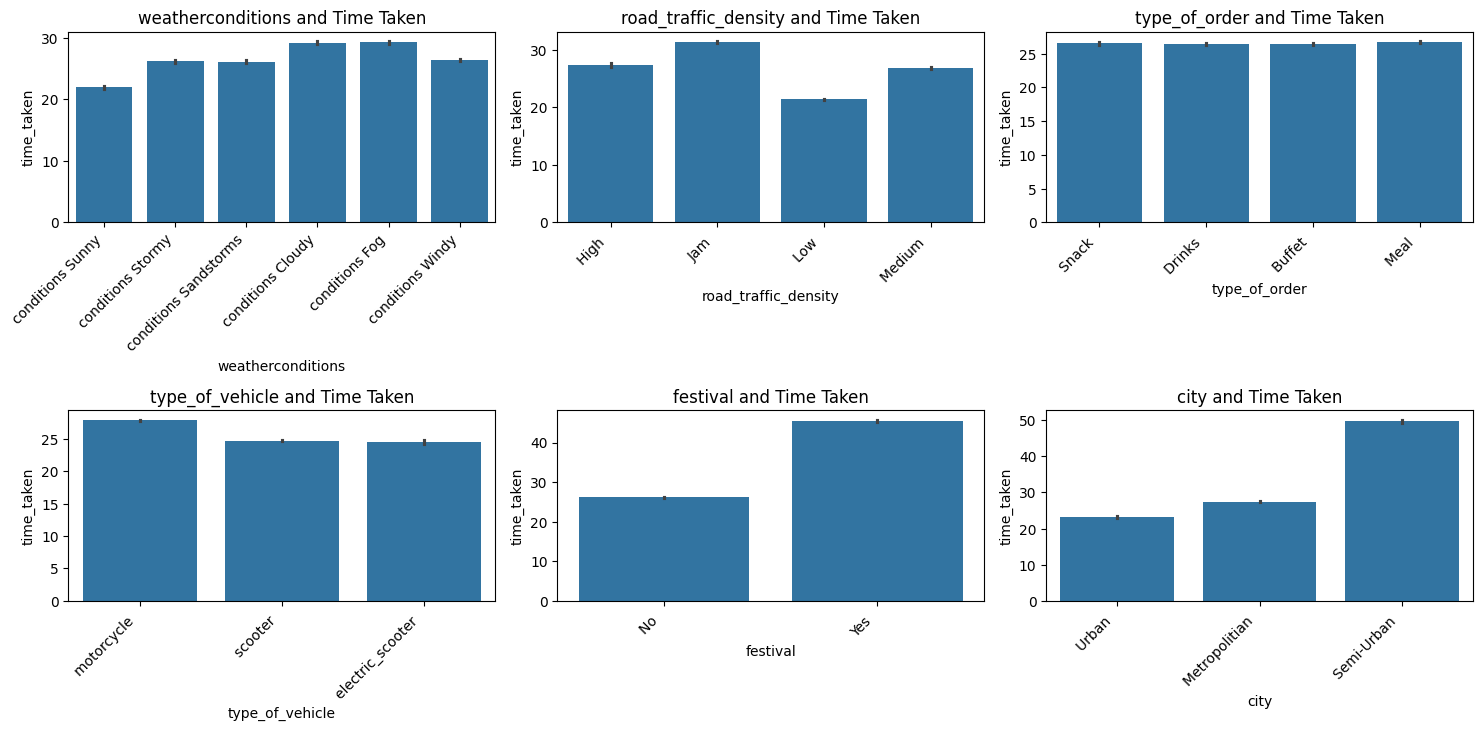

In [60]:
plt.figure(figsize=(15, 10))
for i,col in enumerate(cat_cols):
  plt.subplot(3,3,i+1)
  sns.barplot(data=df, x=col, y='time_taken')
  plt.title(f'{col} and Time Taken')
  plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [61]:
# convert categorical column to numerical form
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
cat_cols = df.select_dtypes(include = "object").columns
label_encoder = LabelEncoder()
for col in cat_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [83]:
X = df[['delivery_person_ratings', 'weatherconditions', 'distance', 'road_traffic_density', 'multiple_deliveries',
        'delivery_person_age','vehicle_condition', 'festival','city','type_of_vehicle']]
y = df['time_taken']

In [84]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.15,random_state = 42)

print(f"X_train_shape:{X_train.shape}")
print(f"X_test_shape:{X_test.shape}")
print(f"y_train_shape:{y_train.shape}")
print(f"y_test_shape:{y_test.shape}")

X_train_shape:(32276, 10)
X_test_shape:(5696, 10)
y_train_shape:(32276,)
y_test_shape:(5696,)


In [85]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [87]:
from sklearn.ensemble import RandomForestRegressor

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "SVR": SVR()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"{name}:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R-squared: {r2:.2f}")
    print()

Linear Regression:
MAE: 5.67
MSE: 49.86
RMSE: 7.06
R-squared: 0.42

Decision Tree:
MAE: 3.96
MSE: 26.85
RMSE: 5.18
R-squared: 0.69

Random Forest:
MAE: 3.04
MSE: 14.52
RMSE: 3.81
R-squared: 0.83

SVR:
MAE: 4.87
MSE: 39.07
RMSE: 6.25
R-squared: 0.55



In [86]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [88]:
lr = RandomForestRegressor(random_state=42)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
r2score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(r2score)
print(mae)
print(mse)

0.8295306648033691
3.044351269897003
14.665546049669357


In [89]:
from sklearn.model_selection import cross_val_score

In [90]:
model = RandomForestRegressor(random_state=42)

In [91]:
cv_scores = cross_val_score(model, X, y, scoring='r2', cv=5)

In [92]:
mean_r2 = cv_scores.mean()
std_r2 = cv_scores.std()

print(f"Mean R2 score from cross-validation: {mean_r2:.4f}")
print(f"Standard deviation of R2 scores from cross-validation: {std_r2:.4f}")

Mean R2 score from cross-validation: 0.8232
Standard deviation of R2 scores from cross-validation: 0.0042


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [10, 20, 30, None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2')

In [ ]:
best_model = grid_search.best_estimator_

In [ ]:
y_pred_best = best_model.predict(X_test)
r2_best = r2_score(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)

best_params = grid_search.best_params_

print(best_model.get_params())
print(best_params)

print(f"Best Model Performance on Test Set:")
print(f"R2 Score: {r2_best:.4f}")
print(f"MAE: {mae_best:.4f}")
print(f"MSE: {mse_best:.4f}")

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}
Best Model Performance on Test Set:
R2 Score: 0.8465
MAE: 2.9459
MSE: 13.2050


In [93]:
final_rf = RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=300, random_state=42)
final_rf.fit(X_train, y_train)
final_y_pred = final_rf.predict(X_test)
final_r2_score = r2_score(y_test, final_y_pred)
final_mae = mean_absolute_error(y_test, final_y_pred)
final_mse = mean_squared_error(y_test, final_y_pred)
print(f"Final Model Performance on Test Set:")
print(f"R2 Score: {final_r2_score:.4f}")
print(f"MAE: {final_mae:.4f}")
print(f"MSE: {final_mse:.4f}")

Final Model Performance on Test Set:
R2 Score: 0.8464
MAE: 2.9474
MSE: 13.2161


In [94]:
cv_scores = cross_val_score(final_rf, X, y, scoring='r2', cv=5)

In [95]:
mean_r2 = cv_scores.mean()
std_r2 = cv_scores.std()

print(f"Mean R2 score from cross validation: {mean_r2:.4f}")
print(f"Standard deviation of R2 scores from cross validation: {std_r2:.4f}")

Mean R2 score from cross validation: 0.8408
Standard deviation of R2 scores from cross validation: 0.0015
